## [Linear] Artificial neural networks

<img src="neuron.jpg" width="" align="" />

### DFT as Neural Network

Discrete Fourier Transform (DFT) by a single layer neural network with a linear transfer function W.

A single layer network, with no bias, no activation function, and particular values for the weights.

The number of output nodes is equal to the number of frequencies we evaluate.

<img src="Radix-2_FFT_butterfly_diagram.png" width="" align="" />

$\begin{matrix}y_k &= {\displaystyle \sum_{n=0}^{N-1}} x_n \cdot \exp(-j\frac{2 \pi k}{N}n)\\ \\
[y_0... y_{N-1}] &= [x_0... x_{N-1}]
\begin{bmatrix}
    \exp(0)     & \exp(0)                     & \exp(0)                      & \dots  & \exp(0) \\
    \exp(0)     & \exp(-i\frac{2\pi}{N})      & \exp(-i\frac{2\pi2}{N})      & \dots  & \exp(-i\frac{2\pi(N-1)}{N}) \\
    \exp(0)     & \exp(-i\frac{2\pi}{N}2)     & \exp(-i\frac{2\pi2}{N}2)     & \dots  & \exp(-i\frac{2\pi(N-1)}{N}2)\\
    \exp(0)     & \exp(-i\frac{2\pi}{N}3)     & \exp(-i\frac{2\pi2}{N}3)     & \dots  & \exp(-i\frac{2\pi(N-1)}{N}3)\\
    \vdots      & \vdots                      & \vdots                       &        & \vdots \\
    \exp(0)     & \exp(-i\frac{2\pi}{N}(N-1)) & \exp(-i\frac{2\pi2}{N}(N-1)) & \dots  & \exp(-i\frac{2\pi(N-1)}{N}(N-1))
\end{bmatrix}\\ \\
\boldsymbol{y} &= \boldsymbol{x} W   
\end{matrix}$

A single layer network, with no bias, no activation function f(), and particular values for the weights.

The number of output nodes is equal to the number of frequencies we evaluate.

#### Learning the Fourier transform via gradient-descent

#### Computing the Fourier transform using a set of Fourier weights

In [27]:
import numpy as np               # linear algebra
import pandas as pd              # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt  # data plotting
from matplotlib import rcParams

rcParams['figure.figsize']     = [15,6]
rcParams['lines.markersize']   = 6         # marker size in points
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['axes.titlesize'] = 9
plt.rcParams['figure.dpi']     = 120

import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)

# to avoid annoying warning messages
import warnings
warnings.filterwarnings('ignore')

In [28]:
def create_fourier_weights(signal_length):  #Función que genera los ángulos de la función según su pares de índices de la función.
    "Create weights, as described above."
    k_vals, n_vals = np.mgrid[0:signal_length, 0:signal_length]
    theta_vals = 2 * np.pi * k_vals * n_vals / signal_length
    return np.hstack([np.cos(theta_vals), -np.sin(theta_vals)])


First half of inputs/outputs is real part, second half is imaginary part

$\exp(-j \frac{2 \pi k}{N}n) = \cos(\frac{2 \pi k}{N}n) - j \sin(\frac{2 \pi k}{N}n)$

In [29]:
# Generate data:
signal_length = 512
x = np.random.random(size=[1, signal_length]) - 0.5  #Genera una matriz de dimensión [1,N] en el que cada valor es un numero aleatoria entre 0 y1. Luego se resta por 0.5 = Genera ruido alrededor del cero

# compare the above implementation with conventional FFT
                # Compute Fourier transform using method described above:
W_fourier = create_fourier_weights(signal_length)
y = np.matmul(x, W_fourier)  # matriz resultante de la señal en el dominio de la frecuencia

                # Compute Fourier transform using the fast Fourier transform:
fft = np.fft.fft(x)
y_fft = np.hstack([fft.real, fft.imag])

                # error estimate
print('rmse: ', np.sqrt(np.mean((y - y_fft)**2)))

rmse:  4.1491110207321014e-13


 checking  to reconstruct the signal:

In [30]:
y_real = y[:, :signal_length]
y_imag = y[:, signal_length:]
tvals = np.arange(signal_length).reshape([-1, 1])
freqs = np.arange(signal_length).reshape([1, -1])
arg_vals = 2 * np.pi * tvals * freqs / signal_length
sinusoids = (y_real * np.cos(arg_vals) - y_imag * np.sin(arg_vals)) / signal_length
reconstructed_signal = np.sum(sinusoids, axis=1)

rmse: 2.0579637194780702e-14


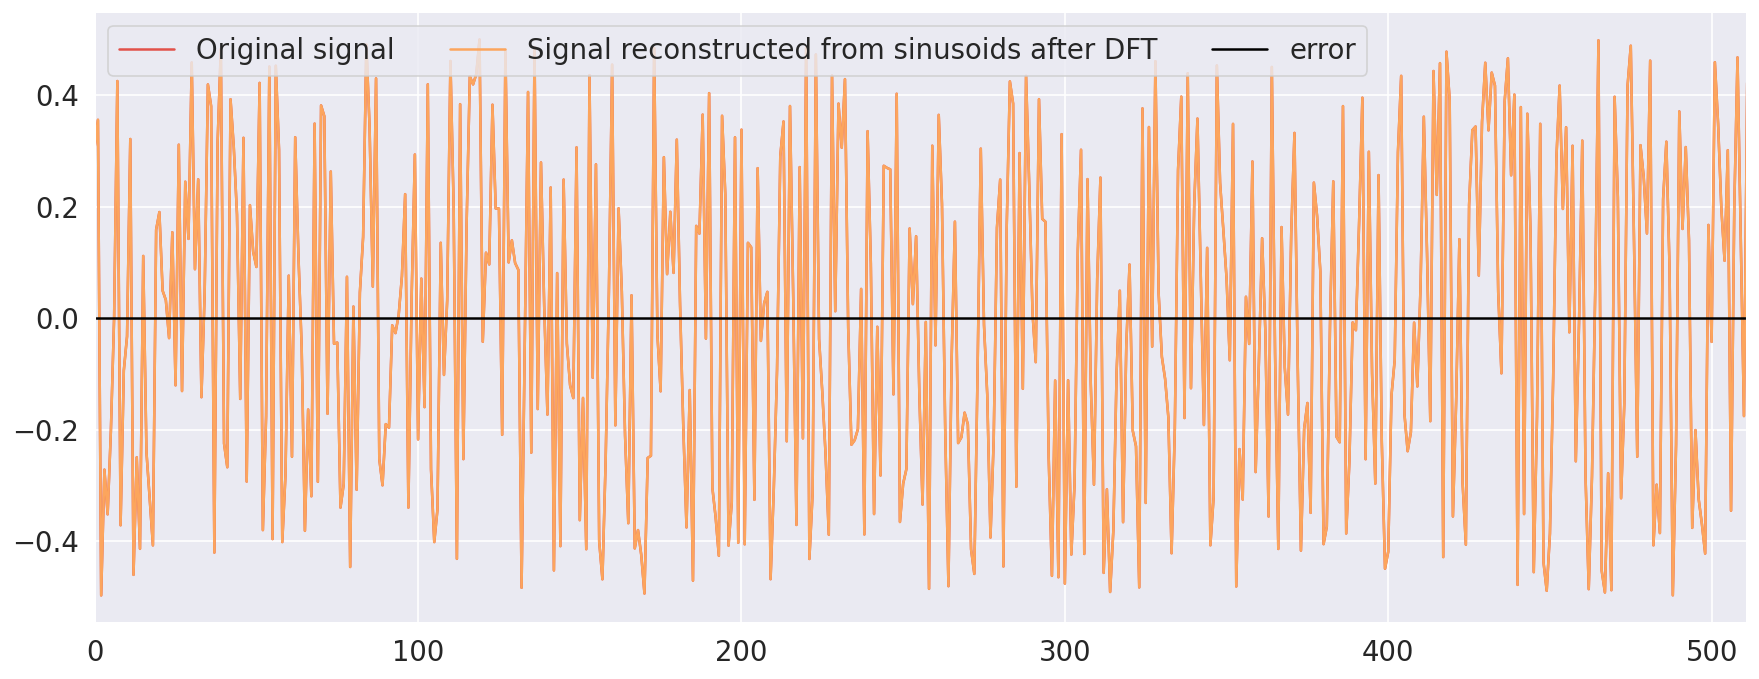

In [31]:
print('rmse:', np.sqrt(np.mean((x - reconstructed_signal)**2)))

plt.plot(x[0,:],label='Original signal')
plt.plot(reconstructed_signal,label='Signal reconstructed from sinusoids after DFT')
plt.plot(abs(x[0,:]-reconstructed_signal),'k',label='error')
plt.xlim(0,signal_length-1)
plt.tight_layout();plt.legend(ncols=3)
plt.show()

#### Learning the Fourier transform via gradient-descent

In [12]:
import tensorflow as tf
signal_length = 512

# Initialise weight vector to train:
W_learned = tf.Variable(np.random.random([signal_length, 2 * signal_length]) - 0.5)

# Expected weights, for comparison:
W_expected = create_fourier_weights(signal_length)

losses  = []
rmses   = []
Ntrials = 1024

for i in range(Ntrials):
    # Generate a random signal each iteration:
    x = np.random.random([1, signal_length]) - 0.5

    # Compute the expected result using the FFT:
    fft = np.fft.fft(x)
    y_true = np.hstack([fft.real, fft.imag])

    with tf.GradientTape() as tape:
        y_pred = tf.matmul(x, W_learned)
        loss = tf.reduce_sum(tf.square(y_pred - y_true))

    # Train weights, via gradient descent:
    W_gradient = tape.gradient(loss, W_learned)
    W_learned = tf.Variable(W_learned - 0.1 * W_gradient)

    losses.append(loss)
    rmses.append(np.sqrt(np.mean((W_learned - W_expected)**2)))

Final loss value = tf.Tensor(1.3201067934585654e+46, shape=(), dtype=float64) Final weights´ rmse = 1.47800031666591e+21
rmse: 0.4201910497819196


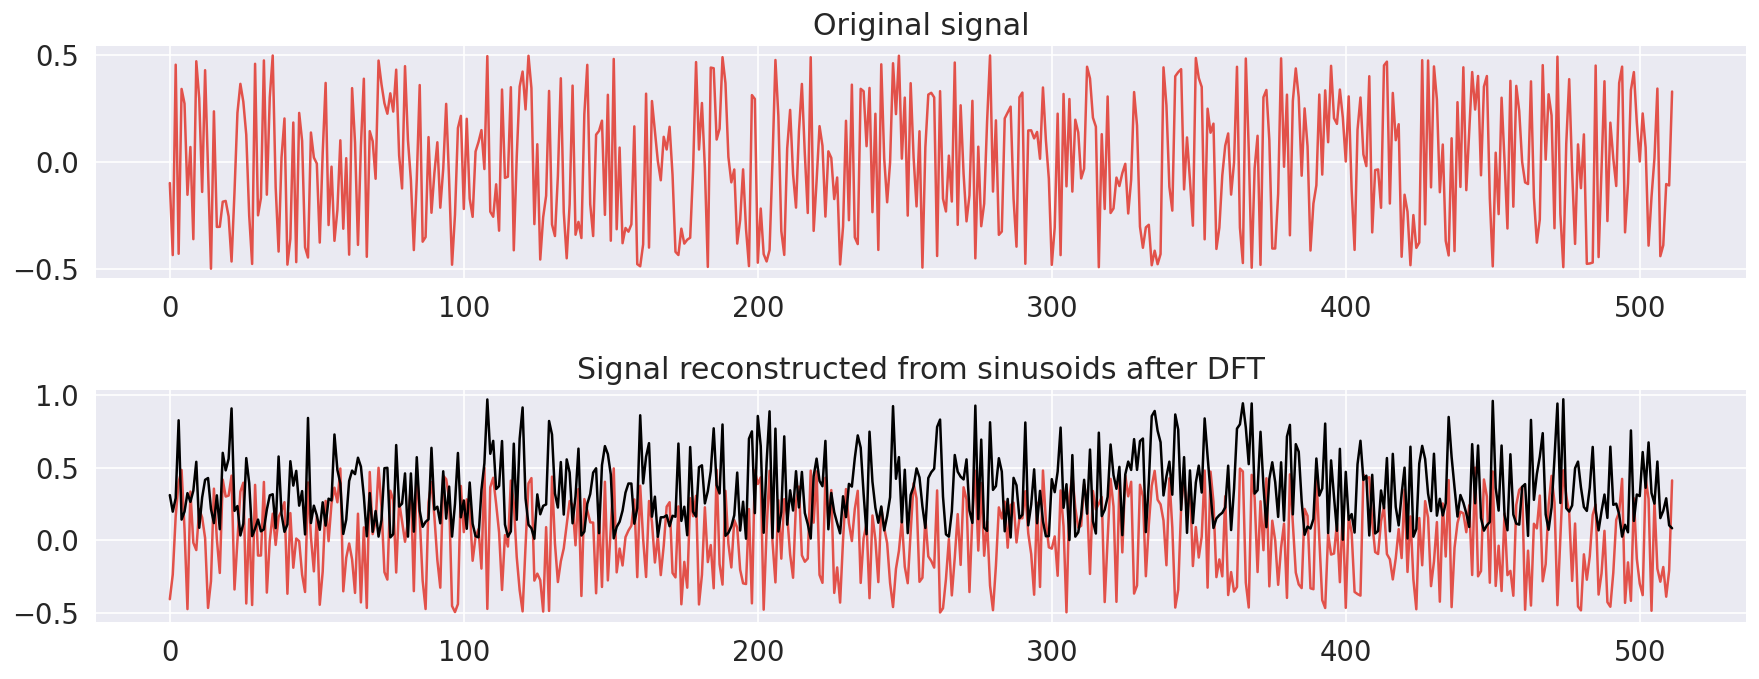

In [13]:
print('Final loss value =',loss,'Final weights´ rmse =',np.sqrt(np.mean((W_learned - W_expected)**2)))
print('rmse:', np.sqrt(np.mean((x - reconstructed_signal)**2)))

plt.subplot(2, 1, 1)
plt.plot(x[0,:])
plt.title('Original signal')
plt.subplot(2, 1, 2)
plt.plot(reconstructed_signal)
plt.plot(abs(x[0,:]-reconstructed_signal),'k',label='error')
plt.title('Signal reconstructed from sinusoids after DFT')
plt.tight_layout()
plt.show()

#### Learning the Fourier transform via reconstruction

In [14]:
W_learned = tf.Variable(np.random.random([signal_length, 2 * signal_length]) - 0.5)
#A variable maintains shared, persistent state manipulated by a program.
tvals = np.arange(signal_length).reshape([-1, 1])
freqs = np.arange(signal_length).reshape([1, -1])
arg_vals = 2 * np.pi * tvals * freqs / signal_length
cos_vals = tf.cos(arg_vals) / signal_length
sin_vals = tf.sin(arg_vals) / signal_length

losses = []
rmses = []

for i in range(10*Ntrials):
    x = np.random.random([1, signal_length]) - 0.5

    #Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        y_pred = tf.matmul(x, W_learned)
        y_real = y_pred[:, 0:signal_length]
        y_imag = y_pred[:, signal_length:]
        sinusoids = y_real * cos_vals - y_imag * sin_vals
        reconstructed_signal = tf.reduce_sum(sinusoids, axis=1)
        # Compute the sum of elements across dimensions of a tensor.
        loss = tf.reduce_sum(tf.square(x - reconstructed_signal))

    W_gradient = tape.gradient(loss, W_learned)
    W_learned = tf.Variable(W_learned - 0.5 * W_gradient)

    losses.append(loss)
    rmses.append(np.sqrt(np.mean((W_learned - W_expected)**2)))

print('Final loss value =',loss,'Final weights´ rmse =',np.sqrt(np.mean((W_learned - W_expected)**2)))

Final loss value = tf.Tensor(2.1826602494179346, shape=(), dtype=float64) Final weights´ rmse = 0.25240148181221894


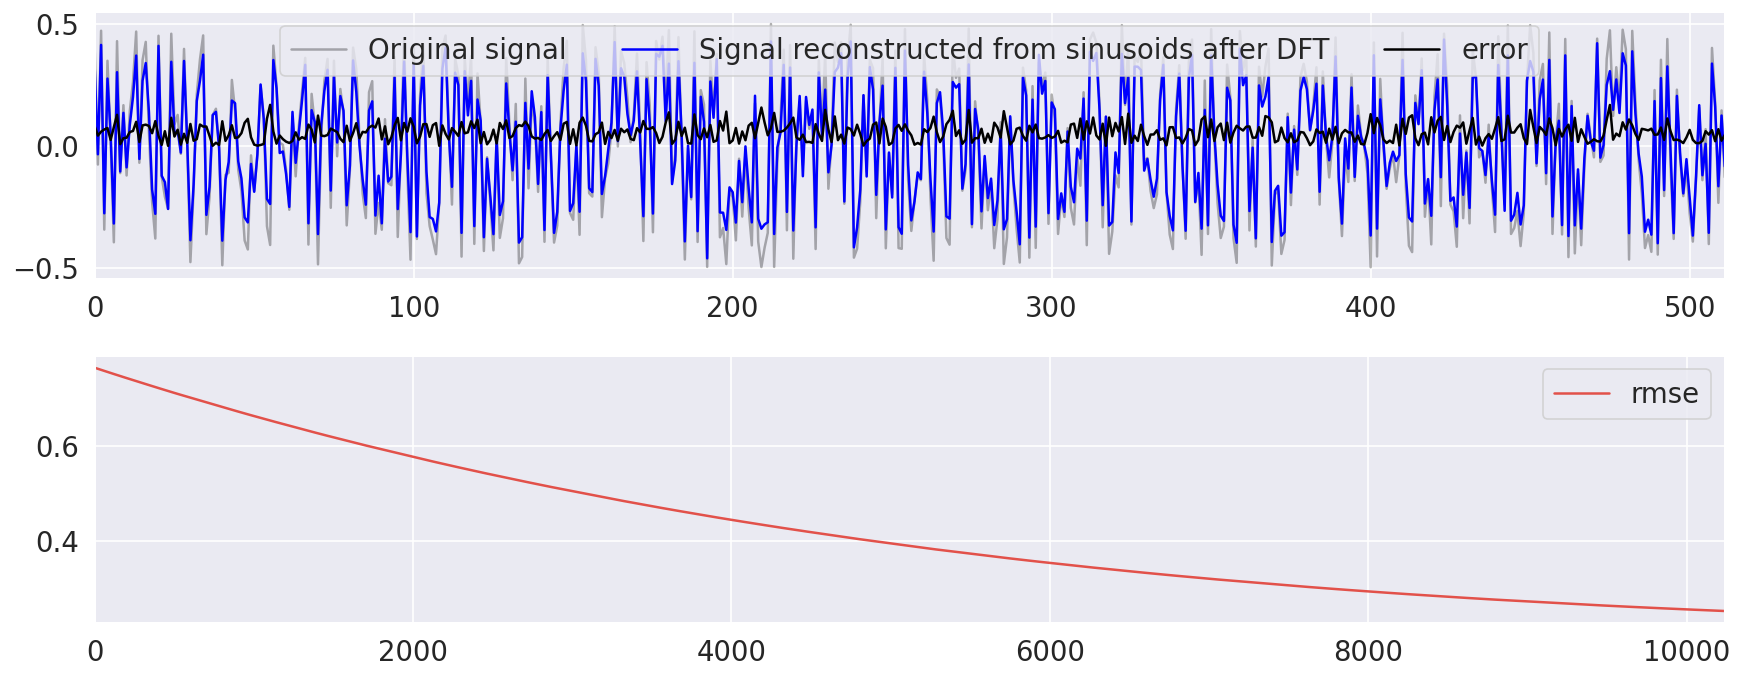

In [15]:
plt.subplot(2, 1, 1)
plt.plot(x[0,:],'k',label='Original signal',alpha=.3)
plt.plot(reconstructed_signal,'b',label='Signal reconstructed from sinusoids after DFT')
plt.plot(abs(x[0,:]-reconstructed_signal),'k',label='error')
plt.xlim(0,signal_length-1)
plt.tight_layout();plt.legend(ncols=3)
plt.subplot(2, 1, 2)
plt.plot(rmses, label='rmse')
plt.xlim(0,len(rmses))
plt.tight_layout();plt.legend()
plt.show()

> https://sidsite.com/posts/fourier-nets/

https://github.com/keras-team/keras

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b8cd8a89-1955-4708-8e62-136598b5b723' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>